GENERATION DE DATAS

# Imports

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import cv2
import os
import ast
import albumentations as A
from tqdm import tqdm

# Load Images

In [6]:
image = cv2.imread("./data_ASL/A/A0.jpg")

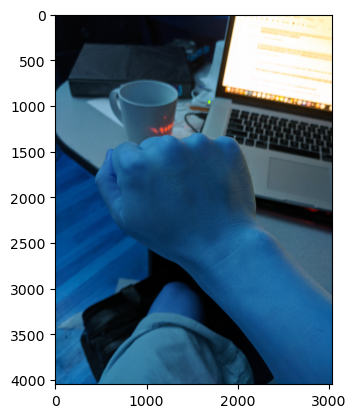

In [7]:
plt.imshow(image)

In [8]:
image.shape

(4048, 3036, 3)

In [9]:
# Image info
img_ht = int(image.shape[0])
img_wd = int(image.shape[1])

print(f'Image height: {img_ht}')
print(f'Image width: {img_wd}')

Image height: 4048
Image width: 3036


# Show image and Bounding Box Function

In [10]:
# Inspired by Venelin Valkov
# Source: https://www.curiousily.com/posts/image-data-augmentation-for-tensorflow-2-keras-and-pytorch-with-albumentations-in-python/
category_id_to_name = {0: 'A', 
                       1: 'B',
                       2: 'C', 
                       3: 'D',
                       4: 'E', 
                       5: 'F',
                       6: 'G', 
                       7: 'H',
                       8: 'I', 
                       9: 'J',
                       10: 'K',
                       11: 'L',
                       12: 'M',
                       13: 'N',
                       14: 'O',
                       15: 'P',
                       16: 'Q',
                       17: 'R',
                       18: 'S',
                       19: 'T',
                       20: 'U',
                       21: 'V',
                       22: 'W',
                       23: 'X',
                       24: 'Y',
                       25: 'Z',
                       }


In [11]:
def show_augmented(augmentation, image):
    augmented = augmentation(image=image)
    augmented_image = augmented['image']  # Extraire l'image transformée
    plt.imshow(cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))  # Convertir BGR en RGB
    plt.axis('off')
    plt.show()

In [12]:
# Source: https://github.com/albumentations-team/albumentations_examples/blob/master/notebooks/example_bboxes.ipynb
aug = A.Compose([
    A.LongestMaxSize(max_size=1024),
    A.PadIfNeeded(min_height=1024, min_width=1024, border_mode=0, p=1.0),
    A.ShiftScaleRotate(shift_limit=.25, scale_limit=0.2, p=0.3),
    A.RandomSizedCrop((900, 1000), 1024, 1024, p=.2),
    A.HorizontalFlip(p=.5),
    A.Rotate(limit=30, p=.8),
    A.MultiplicativeNoise(p=.2),
    A.RGBShift(r_shift_limit=40, g_shift_limit=40, b_shift_limit=40, p=.3),
    A.Blur(blur_limit=25, p=.2),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.35, p=.5),
    A.HueSaturationValue(p=.3),
    A.CoarseDropout(max_holes=9, min_width=30, max_width=250, min_height=30, max_height=250, p=.2),
    A.OneOf([
        A.GaussianBlur(blur_limit=(3, 7), p=0.2),
        A.ImageCompression(quality_lower=50, quality_upper=100, p=0.2),
    ], p=0.2),
    A.OneOf([
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1)
    ], p=0.2),
    A.OneOf([
        A.Sharpen(p=0.2),
        A.Emboss(p=0.2),
        A.RandomBrightnessContrast(p=0.2),
        A.RandomGamma(gamma_limit=(50, 200), p=.2),
        A.ToGray(p=0.2)
    ], p=0.3),
    A.NoOp(p=.04)
])


C:\Users\pH\AppData\Roaming\Python\Python312\site-packages\pydantic\main.py:426: UserWarning: Pydantic serializer warnings:
  Expected `dict[str, any]` but got `UniformParams` with value `UniformParams(noise_type=...2, 0.1568627450980392)])` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


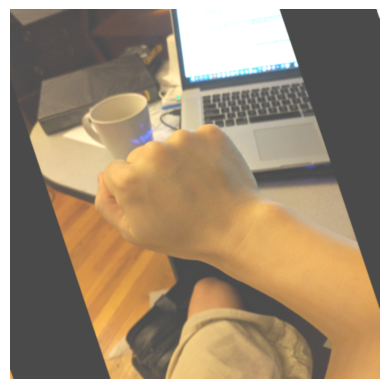

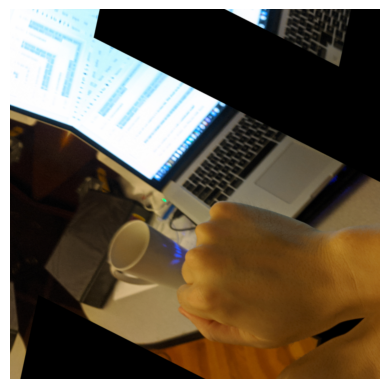

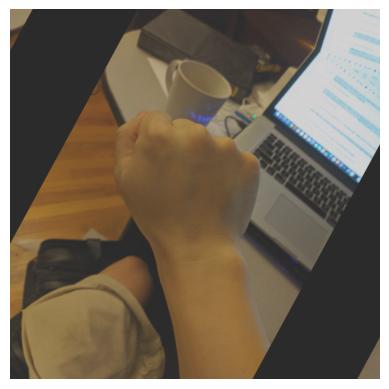

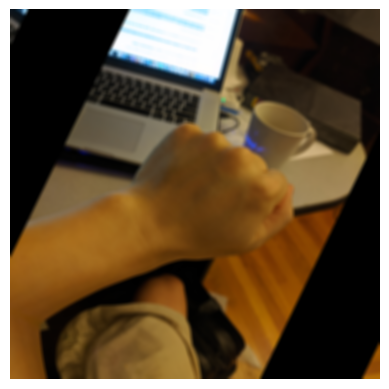

In [13]:
for i in range(4):
    show_augmented(aug, image)

# Creating Augmented Dataset


In [14]:
# Définir les chemins
path1 = 'data_ASL'
DATASET_PATH = 'data_ASL_aug'
os.makedirs(DATASET_PATH, exist_ok=True)

# Parcourir les dossiers et les fichiers
for folder in os.listdir(path1):
    input_folder_path = os.path.join(path1, folder)
    output_folder_path = os.path.join(DATASET_PATH, folder)
    os.makedirs(output_folder_path, exist_ok=True)  # Créer le dossier de sortie

    for filename in os.listdir(input_folder_path):
        file_path = os.path.join(input_folder_path, filename)
        image = cv2.imread(file_path)

        # Vérifier si l'image est correctement chargée
        if image is None:
            print(f"Erreur : Impossible de charger l'image {file_path}.")
            continue

        # Convertir en RGB pour compatibilité
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Créer 25 images augmentées
        for i in range(25):
            augmented = aug(image=image)
            augmented_image = augmented['image']

            # Sauvegarder l'image augmentée
            file_name = f'{filename[:-4]}_{i}.jpg'
            output_file_path = os.path.join(output_folder_path, file_name)
            augmented_image_bgr = cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR)
            cv2.imwrite(output_file_path, augmented_image_bgr)
        
        break
    break        
# on pourra toujours enlever option enlevage de pixels